## Imports

In [26]:
import os
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from CRNN.CRNN import CRNN  
import random
import numpy as np
import matplotlib.pyplot as plt
from d2l import torch as d2l
import pandas as pd
from collections import Counter

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Seeding for Reproducibility

In [28]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


## Data Loading

In [29]:
data_dir = "aclImdb"

def read_imdb(data_dir, is_train):
    """Read the IMDb dataset text sequences and labels."""
    data, labels = [], []
    folder = "train" if is_train else "test"
    for label in ["pos", "neg"]:
        label_dir = os.path.join(data_dir, folder, label)
        for filename in os.listdir(label_dir):
            with open(os.path.join(label_dir, filename), "r", encoding="utf-8") as f:
                data.append(f.read())
            labels.append(1 if label == "pos" else 0)
    return data, labels

def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    from d2l import torch as d2l
    train_data, train_labels = read_imdb(data_dir, is_train=True)
    test_data, test_labels = read_imdb(data_dir, is_train=False)

    train_tokens = d2l.tokenize(train_data, token="word")
    test_tokens = d2l.tokenize(test_data, token="word")
    vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=["<pad>"])

    train_features = torch.tensor(
        [d2l.truncate_pad(vocab[line], num_steps, vocab["<pad>"]) for line in train_tokens]
    )
    test_features = torch.tensor(
        [d2l.truncate_pad(vocab[line], num_steps, vocab["<pad>"]) for line in test_tokens]
    )
    train_labels = torch.tensor(train_labels)
    test_labels = torch.tensor(test_labels)

    train_dataset = TensorDataset(train_features, train_labels)
    test_dataset = TensorDataset(test_features, test_labels)

    train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_iter = DataLoader(test_dataset, batch_size=batch_size)

    return train_iter, test_iter, vocab

# Load dataset
batch_size = 64
num_steps = 500
train_iter, test_iter, vocab = load_data_imdb(batch_size, num_steps)

In [30]:
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 49347


## Model Loading

In [31]:
# Load CRNN model
crnn_model_path = "./CRNN/checkpoints/crnn_best_model.pt"
embed_dim = 100
hidden_dim = 64
output_dim = 2
crnn = CRNN(len(vocab), embed_dim, hidden_dim, output_dim)
crnn.load_state_dict(torch.load(crnn_model_path, map_location=device))
crnn = crnn.to(device)



C:\Users\jonec\AppData\Local\Temp\ipykernel_10748\4192591679.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  crnn.load_state_dict(torch.load(crnn_model_path, map_locatio

In [32]:
# Load RNN model
rnn_model_path = "./best_rnn_model.pth"
class BiRNN(nn.Module): 
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        outputs, _ = self.encoder(embeddings)
        outs = torch.cat((outputs[0], outputs[-1]), dim=1)
        return self.decoder(outs)

num_hiddens, num_layers = 100, 2
rnn = BiRNN(len(vocab), embed_dim, num_hiddens, num_layers)
rnn.load_state_dict(torch.load(rnn_model_path, map_location=device))
rnn = rnn.to(device)

C:\Users\jonec\AppData\Local\Temp\ipykernel_10748\555665781.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn.load_state_dict(torch.load(rnn_model_path, map_location=

In [ ]:
# Load CNN model
cnn_model_path = "./weights/best_cnn_model.pth"
class TextCNN(nn.Module):  
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels, **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        embeddings = torch.cat(
            (self.embedding(inputs), self.constant_embedding(inputs)), dim=2
        ).permute(0, 2, 1)
        encoding = torch.cat(
            [self.relu(self.pool(conv(embeddings)).squeeze(-1)) for conv in self.convs],
            dim=1,
        )
        outputs = self.decoder(self.dropout(encoding))
        return outputs

kernel_sizes, num_channels = [3, 4, 5], [100, 100, 100]
cnn = TextCNN(len(vocab), embed_dim, kernel_sizes, num_channels)
cnn.load_state_dict(torch.load(cnn_model_path, map_location=device))
cnn = cnn.to(device)

C:\Users\jonec\AppData\Local\Temp\ipykernel_10748\2311503228.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load(cnn_model_path, map_location

## Eval

In [34]:
def evaluate_model_imdb(model, data_iter, device, criterion):
    """Evaluate model performance on the test set, including loss."""
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            
            total_loss += loss.item() * y.size(0)
            total_samples += y.size(0)
            
            y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())
            y_true.extend(y.cpu().numpy())

    avg_loss = total_loss / total_samples
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="binary")
    recall = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")

    return avg_loss, acc, precision, recall, f1

def evaluate_test_set(model, test_file_path, vocab, device):
    """
    Evaluate the model on the provided test set.
    
    Args:
        model: Trained PyTorch model to evaluate.
        test_file_path: Path to the test dataset CSV file (text, label).
        vocab: Vocabulary object to tokenize the text data.
        device: Device (CPU or GPU) to run the evaluation.
    
    Returns:
        metrics: Dictionary containing accuracy, precision, recall, F1 score.
    """
    test_data = pd.read_csv(test_file_path)
    texts, labels = test_data['text'].tolist(), test_data['label'].tolist()

    tokenized_texts = [vocab[token] for token in d2l.tokenize(texts, token='word')]
    max_len = 500 
    features = torch.tensor([d2l.truncate_pad(tokens, max_len, vocab['<pad>']) for tokens in tokenized_texts])
    labels = torch.tensor(labels)

    test_dataset = torch.utils.data.TensorDataset(features, labels)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            predictions = torch.argmax(outputs, axis=1).cpu().numpy()
            y_pred.extend(predictions)
            y_true.extend(y.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="binary")
    recall = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}

In [35]:
criterion = nn.CrossEntropyLoss()

## Eval on aclimdb test set

In [36]:
cnn_test_loss, cnn_acc, cnn_precision, cnn_recall, cnn_f1 = evaluate_model_imdb(cnn, test_iter, device, criterion)
print(f"CNN Model - Test Loss: {cnn_test_loss:.4f}, Accuracy: {cnn_acc:.4f}, "
      f"Precision: {cnn_precision:.4f}, Recall: {cnn_recall:.4f}, F1 Score: {cnn_f1:.4f}")

CNN Model - Test Loss: 0.4298, Accuracy: 0.8426, Precision: 0.7899, Recall: 0.9334, F1 Score: 0.8557


In [37]:
rnn_test_loss, rnn_acc, rnn_precision, rnn_recall, rnn_f1 = evaluate_model_imdb(rnn, test_iter, device, criterion)
print(f"RNN Model - Test Loss: {rnn_test_loss:.4f}, Accuracy: {rnn_acc:.4f}, "
      f"Precision: {rnn_precision:.4f}, Recall: {rnn_recall:.4f}, F1 Score: {rnn_f1:.4f}")

RNN Model - Test Loss: 0.3208, Accuracy: 0.8650, Precision: 0.8844, Recall: 0.8398, F1 Score: 0.8615


In [38]:
crnn_test_loss, crnn_acc, crnn_precision, crnn_recall, crnn_f1 = evaluate_model_imdb(crnn, test_iter, device, criterion)
print(f"CRNN Model - Test Loss: {crnn_test_loss:.4f}, Accuracy: {crnn_acc:.4f}, "
      f"Precision: {crnn_precision:.4f}, Recall: {crnn_recall:.4f}, F1 Score: {crnn_f1:.4f}")

CRNN Model - Test Loss: 0.3633, Accuracy: 0.8512, Precision: 0.8361, Recall: 0.8738, F1 Score: 0.8545


## Eval on actual test set

In [39]:
test_file_path = "./test_data_movie.csv"

In [40]:
metrics = evaluate_test_set(cnn, test_file_path, vocab, device)

print("CNN Model Evaluation:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")


Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.80      0.87     20019
    Positive       0.83      0.96      0.89     19981

    accuracy                           0.88     40000
   macro avg       0.89      0.88      0.88     40000
weighted avg       0.89      0.88      0.88     40000

CNN Model Evaluation:
Accuracy: 0.8822
Precision: 0.8308
Recall: 0.9596
F1 Score: 0.8905


In [41]:
metrics = evaluate_test_set(rnn, test_file_path, vocab, device)

print("RNN Model Evaluation:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")


Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.92      0.89     20019
    Positive       0.91      0.87      0.89     19981

    accuracy                           0.89     40000
   macro avg       0.89      0.89      0.89     40000
weighted avg       0.89      0.89      0.89     40000

RNN Model Evaluation:
Accuracy: 0.8921
Precision: 0.9124
Recall: 0.8672
F1 Score: 0.8892


In [42]:
metrics = evaluate_test_set(crnn, test_file_path, vocab, device)

print("CRNN Model Evaluation:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")


Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.87      0.89     20019
    Positive       0.88      0.91      0.89     19981

    accuracy                           0.89     40000
   macro avg       0.89      0.89      0.89     40000
weighted avg       0.89      0.89      0.89     40000

CRNN Model Evaluation:
Accuracy: 0.8910
Precision: 0.8769
Recall: 0.9096
F1 Score: 0.8929


## Combined Model

In [43]:
import torch.nn.functional as F

class CombinedModel(nn.Module):
    def __init__(self, cnn, rnn, crnn, combined_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(CombinedModel, self).__init__()
        self.cnn = cnn
        self.rnn = rnn
        self.crnn = crnn

        # fully connected layers
        self.fc1 = nn.Linear(combined_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        cnn_embedding = self.extract_cnn_embedding(self.cnn, x)
        rnn_embedding = self.extract_rnn_embedding(self.rnn, x)
        crnn_embedding = self.extract_crnn_embedding(self.crnn, x)

        combined_embedding = torch.cat((cnn_embedding, rnn_embedding, crnn_embedding), dim=1)

        x = self.fc1(combined_embedding)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    @staticmethod
    def extract_cnn_embedding(cnn, x):
        """Extract embedding from CNN before its classifier."""
        embeddings = torch.cat(
            (cnn.embedding(x), cnn.constant_embedding(x)), dim=2
        )  
        embeddings = embeddings.permute(0, 2, 1)
        conv_outputs = [cnn.relu(conv(embeddings)) for conv in cnn.convs]
        pooled_outputs = [cnn.pool(conv_out).squeeze(-1) for conv_out in conv_outputs]
        cnn_embedding = torch.cat(pooled_outputs, dim=1)
        return cnn_embedding  

    @staticmethod
    def extract_rnn_embedding(rnn, x):
        """Extract the last hidden state from the BiRNN."""
        embeddings = rnn.embedding(x.T)
        outputs, _ = rnn.encoder(embeddings)
        rnn_embedding = torch.cat((outputs[0], outputs[-1]), dim=1)
        return rnn_embedding  

    @staticmethod
    def extract_crnn_embedding(crnn, x):
        """Extract the last hidden state from the GRU in CRNN."""
        x = crnn.embedding(x)
        x = crnn.embedding_dropout(x)
        x = x.permute(0, 2, 1)
        x = F.relu(crnn.conv(x))
        x = crnn.conv_dropout(x)
        x = x.permute(0, 2, 1)
        _, hidden_state = crnn.gru(x)
        crnn_embedding = hidden_state[-1]  
        return crnn_embedding  


In [44]:
cnn_dim = 300
rnn_dim = 400
crnn_dim = 64  
combined_dim = cnn_dim + rnn_dim + crnn_dim
hidden_dim = 128
output_dim = 2 
dropout_rate = 0.5

combined_model = CombinedModel(cnn, rnn, crnn, combined_dim, hidden_dim, output_dim, dropout_rate).to(device)


In [45]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

freeze_model(cnn)
freeze_model(rnn)
freeze_model(crnn)

# classification layers remain trainable
for param in cnn.decoder.parameters():
    param.requires_grad = True
for param in rnn.decoder.parameters():
    param.requires_grad = True
for param in crnn.fc.parameters():
    param.requires_grad = True


## Train & Eval

In [46]:
# Hyperparameters
num_epochs = 10
learning_rate = 1e-5

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=learning_rate)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
best_test_loss = float('inf')
best_model_path = "best_combined_model.pth"

for epoch in range(num_epochs):
    combined_model.train()
    running_loss = 0.0
    total_samples = 0
    correct_samples = 0

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        outputs = combined_model(X)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        total_samples += y.size(0)
        correct_samples += (torch.argmax(outputs, axis=1) == y).sum().item()

    train_loss = running_loss / total_samples
    train_accuracy = correct_samples / total_samples
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    combined_model.eval()
    test_running_loss = 0.0
    test_total_samples = 0
    test_correct_samples = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(device), y.to(device)
            outputs = combined_model(X)
            loss = criterion(outputs, y)

            test_running_loss += loss.item() * y.size(0)
            test_total_samples += y.size(0)
            test_correct_samples += (torch.argmax(outputs, axis=1) == y).sum().item()

            y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())
            y_true.extend(y.cpu().numpy())

    test_loss = test_running_loss / test_total_samples
    test_accuracy = test_correct_samples / test_total_samples
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(combined_model.state_dict(), best_model_path)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# combined_model.load_state_dict(torch.load(best_model_path))
# print("Best model loaded!")
# combined_model.eval()

# classification report
y_true, y_pred = [], []
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(device), y.to(device)
        outputs = combined_model(X)
        y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())
        y_true.extend(y.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

Epoch 1/10
Train Loss: 0.5691, Train Accuracy: 0.8795
Test Loss: 0.4921, Test Accuracy: 0.8943
Epoch 2/10
Train Loss: 0.3860, Train Accuracy: 0.9489
Test Loss: 0.3716, Test Accuracy: 0.8950
Epoch 3/10
Train Loss: 0.2749, Train Accuracy: 0.9534
Test Loss: 0.3100, Test Accuracy: 0.8943
Epoch 4/10
Train Loss: 0.2125, Train Accuracy: 0.9565
Test Loss: 0.2803, Test Accuracy: 0.8942
Epoch 5/10
Train Loss: 0.1753, Train Accuracy: 0.9586
Test Loss: 0.2663, Test Accuracy: 0.8946
Epoch 6/10
Train Loss: 0.1524, Train Accuracy: 0.9596
Test Loss: 0.2609, Test Accuracy: 0.8944
Epoch 7/10
Train Loss: 0.1367, Train Accuracy: 0.9607
Test Loss: 0.2597, Test Accuracy: 0.8951
Epoch 8/10
Train Loss: 0.1262, Train Accuracy: 0.9618
Test Loss: 0.2612, Test Accuracy: 0.8953
Epoch 9/10
Train Loss: 0.1190, Train Accuracy: 0.9620
Test Loss: 0.2635, Test Accuracy: 0.8952
Epoch 10/10
Train Loss: 0.1124, Train Accuracy: 0.9635
Test Loss: 0.2655, Test Accuracy: 0.8953

Classification Report:
              precision  

## Plots

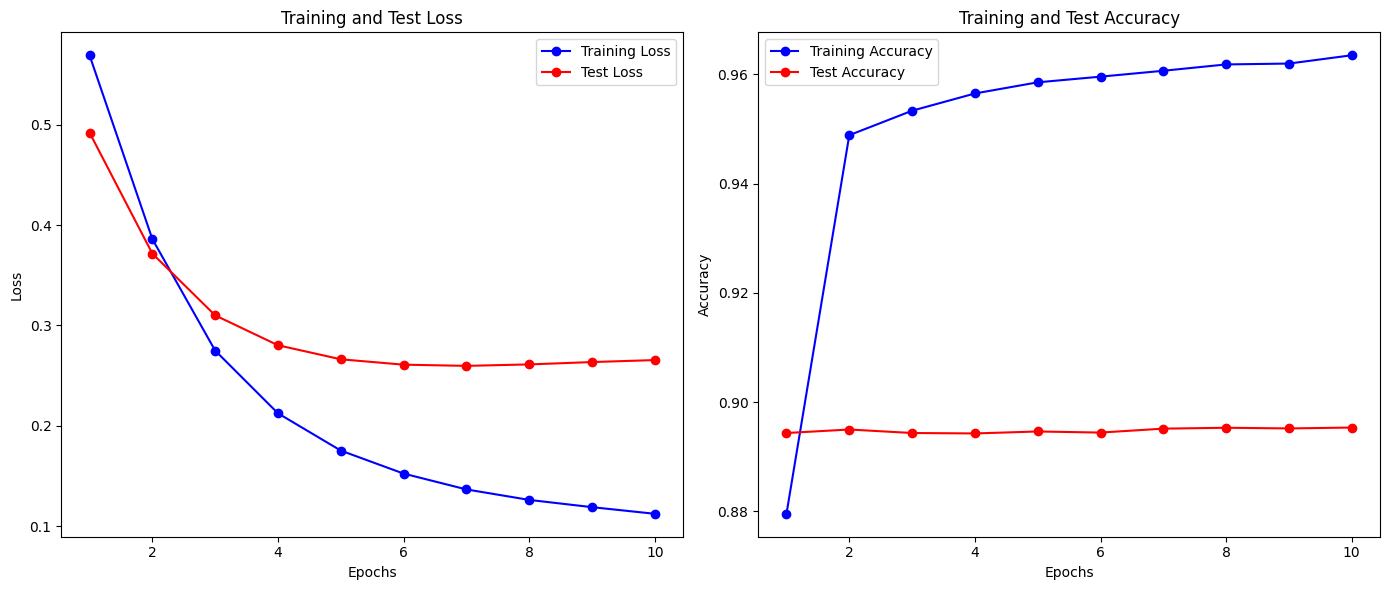

In [48]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
plt.plot(epochs, test_losses, 'r-o', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-o', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r-o', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [49]:
# combined_model.load_state_dict(torch.load(best_model_path))
# print("Best model loaded!")
# combined_model.eval()

metrics = evaluate_test_set(combined_model, test_file_path, vocab, device)

print("Combined Model Evaluation:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")


Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.92      0.93     20019
    Positive       0.92      0.95      0.93     19981

    accuracy                           0.93     40000
   macro avg       0.93      0.93      0.93     40000
weighted avg       0.93      0.93      0.93     40000

Combined Model Evaluation:
Accuracy: 0.9322
Precision: 0.9189
Recall: 0.9480
F1 Score: 0.9332


In [50]:
torch.save(combined_model.state_dict(), best_model_path)